# Example of using filters on text-image datasets

## 5000 ru samples from laion multilingual

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import os
from io import BytesIO
import tarfile
import random

In [2]:
import sys
sys.path.append('../')

In [3]:
df = pd.read_parquet('data/laion-ru-5000samples.parquet')
df.head()

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,LANGUAGE,NSFW,similarity
0,1246634018556_980556,https://spacegid.com:443/wp-content/uploads/20...,NGC 457 - рассеянное скопление,1200,922,?,ru,UNLIKELY,0.307721
1,2539202010529_952552,https://cdn.trinixy.ru/pics5/20150612/monzter_...,В заброшенных зданиях Берлина «поселились» заб...,700,525,?,ru,UNLIKELY,0.307292
2,3402293008486_702748,http://br-stroy.net/assets/cache/thumb/db93a88...,«Техноплаза»: надежный поставщик строительной ...,250,170,?,ru,UNLIKELY,0.262686
3,1052284004926_943595,https://ntdtv.ru/wp-content/uploads/2021/02/No...,Novyj risunok 11 2 - Мужчина не дал собаке уме...,610,458,?,ru,UNLIKELY,0.269311
4,3385783010403_607685,https://touristam.com/wp-content/uploads/2019/...,Copac Hotel 3* (Копак отель) Вьетнам/Нячанг. О...,600,394,?,ru,UNLIKELY,0.266126


### 1) Download images with img2dataset

In [4]:
from img2dataset import download
import shutil
import os

output_dir = "data/images"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

download(
    processes_count=16,
    thread_count=32,
    url_list="data/laion-ru-5000samples.parquet",
    image_size=512,
    resize_mode='keep_ratio',
    resize_only_if_bigger=True,
    encode_format='jpg',
    skip_reencode=True,
    extract_exif=False,
    compute_md5=False,
    output_folder=output_dir,
    output_format="files",
    input_format="parquet",
    url_col="URL",
    caption_col="TEXT",
    save_additional_columns=['SAMPLE_ID'],
    number_sample_per_shard=1000,
    distributor="multiprocessing",
)

Starting the downloading of this file
Sharding file number 1 of 1 called /home/jovyan/pavlov/prepare_datasets/datasets-utils/example/data/laion-ru-5000samples.parquet


0it [00:00, ?it/s]

File sharded in 5 shards


5it [01:14, 14.98s/it]


worker  - success: 0.791 - failed to download: 0.194 - failed to resize: 0.015 - images per sec: 16 - count: 1000
total   - success: 0.791 - failed to download: 0.194 - failed to resize: 0.015 - images per sec: 16 - count: 1000
worker  - success: 0.795 - failed to download: 0.189 - failed to resize: 0.016 - images per sec: 14 - count: 1000
total   - success: 0.793 - failed to download: 0.192 - failed to resize: 0.015 - images per sec: 29 - count: 2000
worker  - success: 0.779 - failed to download: 0.207 - failed to resize: 0.014 - images per sec: 14 - count: 1000
total   - success: 0.788 - failed to download: 0.197 - failed to resize: 0.015 - images per sec: 43 - count: 3000
worker  - success: 0.760 - failed to download: 0.222 - failed to resize: 0.018 - images per sec: 14 - count: 1000
total   - success: 0.781 - failed to download: 0.203 - failed to resize: 0.016 - images per sec: 56 - count: 4000
worker  - success: 0.768 - failed to download: 0.221 - failed to resize: 0.011 - images 

In [5]:
df = pd.read_parquet(f'{output_dir}/00000.parquet')
df.head()

,SAMPLE_ID,caption,url,key,status,error_message,width,height,original_width,original_height
0,1293561002031_477554,Разведение кроликов как бизнес: выращивание де...,https://datchnik.ru/wp-content/uploads/8/3/1/8...,00000012,success,None,671.0,450.0,671.0,450.0
1,1246634018556_980556,NGC 457 - рассеянное скопление,https://spacegid.com:443/wp-content/uploads/20...,00000000,success,None,666.0,512.0,1200.0,922.0
2,1581922005568_259888,Вес школьных ранцев с учебными принадлежностям...,https://ds02.infourok.ru/uploads/ex/0352/00009...,00000017,success,None,640.0,480.0,640.0,480.0
3,3391200015048_119580,Сотрудники пожарной охраны Орловской области п...,https://mchs-orel.ru/wp-content/uploads/2015/0...,00000014,success,None,512.0,683.0,530.0,707.0
4,1172984009420_530545,Ваза с цветами рисунок акварелью для детей,https://avatars.mds.yandex.net/get-pdb/964102/...,00000009,success,None,421.0,600.0,421.0,600.0


Concat all parquets

In [6]:
all_parquets = glob(f'{output_dir}/*.parquet')
print(len(all_parquets))

dfs = [pd.read_parquet(i) for i in tqdm(all_parquets)]
all_df = pd.concat(dfs, ignore_index=True)
print(len(all_df))

5


100%|██████████| 5/5 [00:00<00:00, 125.82it/s]

5000


create *path* column

In [7]:
all_df['shard_id'] = all_df['key'].apply(lambda x: x[:5])
all_df['path'] = output_dir+'/'+all_df['shard_id']+'/'+all_df['key']+'.jpg'

In [8]:
all_df.head()

,SAMPLE_ID,caption,url,key,status,error_message,width,height,original_width,original_height,shard_id,path
0,1293561002031_477554,Разведение кроликов как бизнес: выращивание де...,https://datchnik.ru/wp-content/uploads/8/3/1/8...,00000012,success,None,671.0,450.0,671.0,450.0,00000,data/images/00000/00000012.jpg
1,1246634018556_980556,NGC 457 - рассеянное скопление,https://spacegid.com:443/wp-content/uploads/20...,00000000,success,None,666.0,512.0,1200.0,922.0,00000,data/images/00000/00000000.jpg
2,1581922005568_259888,Вес школьных ранцев с учебными принадлежностям...,https://ds02.infourok.ru/uploads/ex/0352/00009...,00000017,success,None,640.0,480.0,640.0,480.0,00000,data/images/00000/00000017.jpg
3,3391200015048_119580,Сотрудники пожарной охраны Орловской области п...,https://mchs-orel.ru/wp-content/uploads/2015/0...,00000014,success,None,512.0,683.0,530.0,707.0,00000,data/images/00000/00000014.jpg
4,1172984009420_530545,Ваза с цветами рисунок акварелью для детей,https://avatars.mds.yandex.net/get-pdb/964102/...,00000009,success,None,421.0,600.0,421.0,600.0,00000,data/images/00000/00000009.jpg


save parquet with paths

In [9]:
all_df.to_parquet(
    'data/laion-ru-downloaded-info.parquet',
    index=False
)

### 2) Check samples from dataset

In [10]:
df_to_sample = all_df[all_df['status']=='success']
len(df_to_sample)

3893

фотографии отеля Menada Tarsis Apartments изображение №43


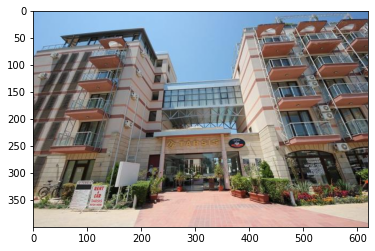

In [11]:
sample = df_to_sample.sample(1).iloc[0]

print(sample['caption'])
plt.imshow(plt.imread(sample['path']))
plt.show()

# Filters

In [12]:
import torch

device = torch.device('cuda:0')
download_weights_root = '../weights'

In [13]:
df = pd.read_parquet('data/laion-ru-downloaded-info.parquet')
df_to_process = df[df['status']=='success']
files = df_to_process['path'].values

### Clean captions with regular expressions

In [14]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
from filters import compile_regexs_ru, compile_regexs_eng, clean_caption, clean_joined_words
compile_regexs_ru() # or compile_regexs_eng()

Can't import package re2, using re package. It is recommended to use more efficient re2 package.


In [16]:
import filters.text_filters
filters.text_filters.clean_captions.compiled_regexs

[(re.compile(r'&quot;?', re.UNICODE), ''),
 (re.compile(r'\d*&#\d*;\d*', re.UNICODE), ''),
 (re.compile(r'\.? купить за \d+ руб\.?', re.UNICODE), ''),
 (re.compile(r'проект \b\d+\-\d+\b', re.UNICODE), ''),
 (re.compile(r'проект \b\d+\w+\b', re.UNICODE), ''),
 (re.compile(r'\d+\s?х\s?\d*,?\.?\d+\s?\d*,?\.?\d*', re.UNICODE), ''),
 (re.compile(r'\b[\d\.]+\s*[xх×\-/]?\s*[\d\.]*\s*[xх×\-/]?\s*[\d\.]*\s*(?:cm|mm|m|km|inch|ct|g|kg|l|ml|w|h|px|b|kb|mb|gb|см|мм|м|км|л|грамм|кг|килограмм|в|вт|квт)\b',
  re.UNICODE),
  ''),
 (re.compile(r'\b\w*[\-|/]?\d+[\-|/]\w*\b', re.UNICODE), ''),
 (re.compile(r'\b[\w]+\.ру', re.UNICODE), ''),
 (re.compile(r'(at )?\b((?:https?:(?:\/{1,3}|[a-zA-Z0-9%])|[a-zA-Z0-9.\-]+[.](?:com|co|ru|net|org|edu|gov|it)[\w/-]*\b\/?(?!@)))',
  re.UNICODE),
  ''),
 (re.compile(r'\.{2,}', re.UNICODE), ' '),
 (re.compile(r'\b[а-яА-Я]{1,3}\d{3,15}\b', re.UNICODE), ''),
 (re.compile(r'\(\s?#?\s?\d+\s?\)', re.UNICODE), ' '),
 (re.compile(r'\b\d{1,4}[-/.]\d{1,4}[-/.]\d{1,4}\b', re.UNIC

In [17]:
%%time

df['cleaned'] = df['caption'].parallel_apply(clean_caption)
df['cleaned'] = df['cleaned'].parallel_apply(clean_joined_words)

CPU times: user 59 ms, sys: 433 ms, total: 492 ms
Wall time: 846 ms


In [19]:
samples = df.sample(5)

for sample in samples.to_dict('records'):
    print('-'*40)
    print(f'[caption]: {sample["caption"]}')
    print(f'[cleaned]: {sample["cleaned"]}')

----------------------------------------
[caption]: Черные кроссовки Nike Internationalist Prm 828043-001 - Черный
[cleaned]: черные кроссовки - черный
----------------------------------------
[caption]: Шкаф лабораторный для документов ШЛДД-107
[cleaned]: шкаф лабораторный для документов шлдд
----------------------------------------
[caption]: Михаил Козаков последние дни жизни провел в пансионате для престарелых. У него было пять жен, пять детей и столько же внуков
[cleaned]: михаил козаков последние дни жизни провел в пансионате для престарелых. у него было пять жен, пять детей и столько же внуков
----------------------------------------
[caption]: Платье с принтом Цветы (разные цвета)
[cleaned]: платье с принтом цветы разные цвета
----------------------------------------
[caption]: Шуба из норки мех норка, цвет черный, арт. 18007289  - цена 75990 руб.  - магазин TOTOGROUP
[cleaned]: шуба из норки мех норка, цвет черный, арт. - цена руб. - магазин totogroup


### Watermarks detection

In [20]:
from filters import ResnetWatermarksPredictor, get_watermarks_detection_model

In [21]:
wdetection_model = get_watermarks_detection_model(
    'resnext101_32x8d-large', # or 'resnext50_32x4d-small'
    device=device,
    cache_dir=download_weights_root
)

In [22]:
dataset_predictor = ResnetWatermarksPredictor(
    wdetection_model,
    save_parquets=True,
    save_parquets_dir='data/',
    device=device,
    workers=16,
    bs=32
)

[2022-07-27 16:43:09,156][INFO]: Logger initialized
[2022-07-27 16:43:09,158][INFO]: Saving dataframes to: data
[2022-07-27 16:43:09,158][INFO]: Using device cuda:0


In [23]:
df_result = dataset_predictor.run(
    task_name='watermarks_detection',
    files=files,
)

[2022-07-27 16:43:09,162][INFO]: Starting task watermarks_detection
[2022-07-27 16:43:09,163][INFO]: Files to process: 3893


100%|██████████| 122/122 [00:16<00:00,  7.44it/s]

[2022-07-27 16:43:25,581][INFO]: Processing task watermarks_detection finished
[2022-07-27 16:43:25,588][INFO]: Parquet saved to data/watermarks_detection.parquet


In [24]:
df_result.head()

,watermark,path
0,0,data/images/00000/00000012.jpg
1,0,data/images/00000/00000000.jpg
2,0,data/images/00000/00000017.jpg
3,0,data/images/00000/00000014.jpg
4,0,data/images/00000/00000009.jpg


Let's check samples with watermarks

In [25]:
df_to_sample = df_result[df_result['watermark']==1]
len(df_to_sample)

848

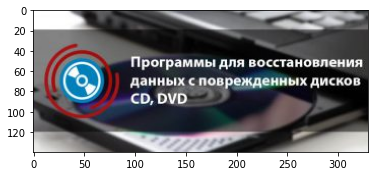

In [48]:
sample = df_to_sample.sample(1).iloc[0]
plt.imshow(plt.imread(sample['path']))
plt.show()

Merge results on main dataframe

In [49]:
df = pd.merge(df, df_result, on='path', how='outer')
len(df)

5000

### Labeling with CLIP

In [50]:
from filters import CLIPPredictor
import clip

In [51]:
clip_model, clip_processor = clip.load(
    "ViT-L/14@336px", 
    device=device,
    download_root=download_weights_root,
)

In [52]:
dataset_predictor = CLIPPredictor(
    clip_model=clip_model, clip_processor=clip_processor,
    save_parquets=True,
    save_parquets_dir='data/',
    device=device,
    workers=16,
    bs=32,
    templates=['{}']
)

[2022-07-27 16:44:25,202][INFO]: Logger initialized
[2022-07-27 16:44:25,204][INFO]: Saving dataframes to: data
[2022-07-27 16:44:25,204][INFO]: CLIP templates: ['{}']


In [53]:
labels_for_clip = [
    "picture has watermark",
    "slide of presentation with text",
    "document with text",
    "web site with text"
]

df_result = dataset_predictor.run(
    task_name='clip_labels',
    files=files,
    labels=labels_for_clip
)

[2022-07-27 16:44:25,208][INFO]: Starting task clip_labels
[2022-07-27 16:44:25,209][INFO]: Files to process: 3893
[2022-07-27 16:44:25,209][INFO]: Labels count: 4


100%|██████████| 122/122 [00:27<00:00,  4.51it/s]

[2022-07-27 16:44:52,294][INFO]: Processing task clip_labels finished
[2022-07-27 16:44:52,305][INFO]: Parquet saved to data/clip_labels.parquet


In [54]:
df_result.head()

,picture has watermark,slide of presentation with text,document with text,web site with text,path
0,0.135376,0.112061,0.135864,0.147583,data/images/00000/00000012.jpg
1,0.168213,0.140259,0.146606,0.165527,data/images/00000/00000000.jpg
2,0.173340,0.236572,0.222534,0.204712,data/images/00000/00000017.jpg
3,0.142578,0.091980,0.133789,0.130371,data/images/00000/00000014.jpg
4,0.169678,0.128662,0.170288,0.165527,data/images/00000/00000009.jpg


Let's check samples with watermarks

In [55]:
df_to_sample = df_result[df_result['picture has watermark']>0.22]
len(df_to_sample)

15

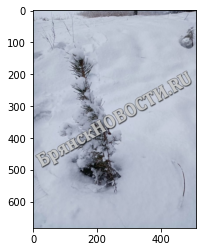

In [57]:
sample = df_to_sample.sample(1).iloc[0]
plt.imshow(plt.imread(sample['path']))
plt.show()

Merge results on main dataframe

In [58]:
df = pd.merge(df, df_result, on='path', how='outer')
len(df)

5000

### ruCLIP similarity between image and caption

In [59]:
from filters import RuCLIPPredictor
import ruclip

In [60]:
ruclip, ruclip_processor = ruclip.load(
    'ruclip-vit-base-patch32-384', 
    device=device, 
    cache_dir=download_weights_root
)

In [61]:
dataset_predictor = RuCLIPPredictor(
    ruclip, ruclip_processor,
    save_parquets=True,
    save_parquets_dir='data/',
    device=device,
    workers=16,
    bs=32
)

[2022-07-27 16:46:31,990][INFO]: Logger initialized
[2022-07-27 16:46:31,991][INFO]: Saving dataframes to: data


In [62]:
files = df_to_process['path'].values
texts = df_to_process['caption'].values

In [63]:
df_result = dataset_predictor.run(
    task_name='ruclip_similarity',
    files=files,
    texts=texts
)

[2022-07-27 16:46:37,961][INFO]: Starting task ruclip_similarity
[2022-07-27 16:46:37,962][INFO]: Files to process: 3893


100%|██████████| 122/122 [00:12<00:00,  9.98it/s]

[2022-07-27 16:46:50,192][INFO]: Processing task ruclip_similarity finished
[2022-07-27 16:46:50,205][INFO]: Parquet saved to data/ruclip_similarity.parquet


In [64]:
df_result.head()

,ruclip_similarity,path,caption
0,21.867205,data/images/00000/00000012.jpg,Разведение кроликов как бизнес: выращивание де...
1,21.941618,data/images/00000/00000000.jpg,NGC 457 - рассеянное скопление
2,16.646236,data/images/00000/00000017.jpg,Вес школьных ранцев с учебными принадлежностям...
3,11.677076,data/images/00000/00000014.jpg,Сотрудники пожарной охраны Орловской области п...
4,18.249224,data/images/00000/00000009.jpg,Ваза с цветами рисунок акварелью для детей


Let's check samples with low ruCLIP similarity

In [65]:
df_to_sample = df_result[df_result['ruclip_similarity']<9]
len(df_to_sample)

77

mikos * Baby manta I Punto I algodón I – Manta I erstling (100 x


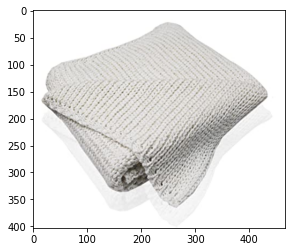

In [67]:
sample = df_to_sample.sample(1).iloc[0]
print(sample['caption'])
plt.imshow(plt.imread(sample['path']))
plt.show()

Merge results on main dataframe

In [68]:
df_to_merge = df_result[['path', 'ruclip_similarity']] # don't need to merge "caption" column
df = pd.merge(df, df_to_merge, on='path', how='outer')
len(df)

5000

### Text area detection

In [69]:
from filters import FastCRAFTPredictor, get_text_detection_model

In [70]:
craft_model = get_text_detection_model(
    'CRAFT-MLT',
    device=device,
    cache_dir=download_weights_root
)

In [71]:
dataset_predictor = FastCRAFTPredictor(
    craft_model,
    save_parquets=True,
    save_parquets_dir='data/',
    device=device,
    workers=16,
    bs=32,
)

[2022-07-27 16:48:24,047][INFO]: Logger initialized
[2022-07-27 16:48:24,048][INFO]: Saving dataframes to: data
[2022-07-27 16:48:24,049][INFO]: Using device cuda:0


In [72]:
df_result = dataset_predictor.run(
    task_name='text_detection',
    files=files,
)

[2022-07-27 16:48:54,559][INFO]: Starting task text_detection
[2022-07-27 16:48:54,560][INFO]: Files to process: 3893


100%|██████████| 122/122 [00:25<00:00,  4.73it/s]

[2022-07-27 16:49:20,376][INFO]: Processing task text_detection finished


[2022-07-27 16:49:20,384][INFO]: Parquet saved to data/text_detection.parquet


In [73]:
df_result.head()

,text_area,path
0,0.000000,data/images/00000/00000012.jpg
1,0.000000,data/images/00000/00000000.jpg
2,0.185469,data/images/00000/00000017.jpg
3,0.000000,data/images/00000/00000014.jpg
4,0.000000,data/images/00000/00000009.jpg


Let's check samples with text area on image more than 30%

In [74]:
df_to_sample = df_result[df_result['text_area']>0.3]
len(df_to_sample)

35

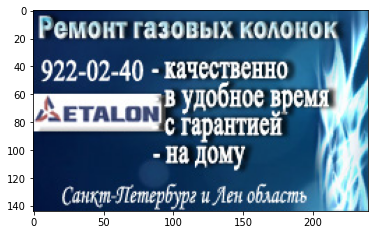

In [75]:
sample = df_to_sample.sample(1).iloc[0]
plt.imshow(plt.imread(sample['path']))
plt.show()

Merge results on main dataframe

In [76]:
df = pd.merge(df, df_result, on='path', how='outer')
len(df)

5000

### Find duplicated images

In [77]:
from filters.image_filters.image_deduplication import ImageDeduplicator

In [78]:
deduplicator = ImageDeduplicator(
    chunk_size=50000, workers=16,
)

[2022-07-27 17:23:44,831][INFO]: Logger initialized
[2022-07-27 17:23:44,832][INFO]: Using PHasher with chunk_size 50000 and 16 workers


if we want to just check duplicates

In [79]:
duplicates_dict = deduplicator.get_duplicates_dict(files)

[2022-07-27 17:23:46,976][INFO]: Encoding


100%|██████████| 3893/3893 [00:01<00:00, 2662.24it/s]


[2022-07-27 17:23:49,852][INFO]: Finding duplicates


2022-07-27 17:23:49,853: INFO Start: Evaluating hamming distances for getting duplicates
2022-07-27 17:23:49,853: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 3893/3893 [00:00<00:00, 7193.86it/s]
2022-07-27 17:24:24,159: INFO End: Retrieving duplicates using BKTree algorithm
2022-07-27 17:24:24,161: INFO End: Evaluating hamming distances for getting duplicates


In [80]:
imgs_with_duplicates = {}
for k, v in duplicates_dict.items():
    if len(v) > 0:
        imgs_with_duplicates[k] = v
        
len(imgs_with_duplicates)

5

duplicates:
data/images/00003/00003818.jpg


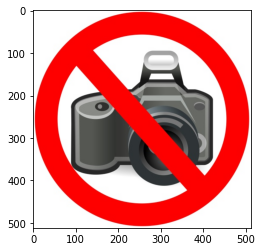

data/images/00003/00003661.jpg


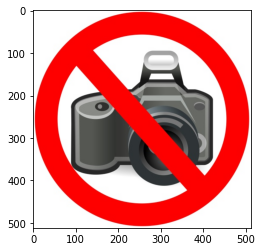

data/images/00003/00003747.jpg


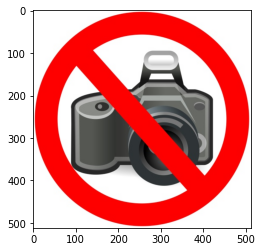

data/images/00001/00001402.jpg


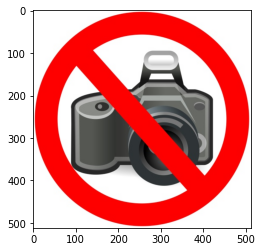

data/images/00004/00004965.jpg


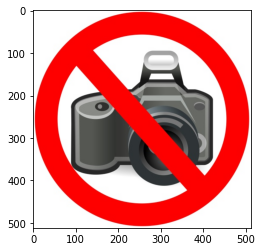

In [81]:
keys = list(imgs_with_duplicates.keys())
name = keys[random.randint(0, len(keys))-1]

print('duplicates:')
print(name)
plt.imshow(plt.imread(name))
plt.show()

for dupname in imgs_with_duplicates[name]:
    print(dupname)
    plt.imshow(plt.imread(dupname))
    plt.show()

if we want to get duplicates names (and delete them)

In [82]:
duplicates = deduplicator.run(
    f'delete_duplicates', 
    files, 
    delete_duplicates=False
)

[2022-07-27 17:30:40,372][INFO]: Starting task delete_duplicates
[2022-07-27 17:30:40,374][INFO]: Files to process: 3893
[2022-07-27 17:30:40,374][INFO]: Delete duplicates = False
[2022-07-27 17:30:40,375][INFO]: Encoding


100%|██████████| 3893/3893 [00:01<00:00, 2587.05it/s]


[2022-07-27 17:30:43,794][INFO]: Finding duplicates


2022-07-27 17:30:43,795: INFO Start: Evaluating hamming distances for getting duplicates
2022-07-27 17:30:43,795: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 3893/3893 [00:03<00:00, 1277.61it/s]
2022-07-27 17:31:20,142: INFO End: Retrieving duplicates using BKTree algorithm
2022-07-27 17:31:20,145: INFO End: Evaluating hamming distances for getting duplicates


[2022-07-27 17:31:20,150][INFO]: Chunk: 0, [0:50000] 4 duplicates
[2022-07-27 17:31:20,151][INFO]: Found total 4 duplicates
[2022-07-27 17:31:20,152][INFO]: Processing task delete_duplicates finished


In [83]:
duplicates

['data/images/00003/00003818.jpg',
 'data/images/00003/00003747.jpg',
 'data/images/00001/00001402.jpg',
 'data/images/00004/00004965.jpg']

In [84]:
df['is_duplicate'] = 0
df.loc[df['path'].isin(duplicates), 'is_duplicate'] = 1

In [85]:
df[df['is_duplicate']==1]

,SAMPLE_ID,caption,url,key,status,error_message,width,height,original_width,original_height,...,path,cleaned,watermark,picture has watermark,slide of presentation with text,document with text,web site with text,ruclip_similarity,text_area,is_duplicate
1719,1328952016385_353983,Что можно и нельзя делать в праздник Рождества...,https://triboona.ru/uploads/posts/2021-09/1632...,00003747,success,None,512.0,512.0,1200.0,1200.0,...,data/images/00003/00003747.jpg,что можно и нельзя делать в праздник рождества...,1.0,0.195801,0.151245,0.182251,0.171631,12.129605,0.0,1
1798,1203979000958_96253,"Какой церковный праздник сегодня, 25 июня, поч...",https://uenews.ru/uploads/posts/2021-06/162453...,00003818,success,None,512.0,512.0,1200.0,1200.0,...,data/images/00003/00003818.jpg,"какой церковный праздник сегодня, 25 июня, поч...",1.0,0.195801,0.151245,0.182251,0.171631,4.573722,0.0,1
3375,2465302000217_175467,Соцмедиа о матче Россия Уругвай: надо было Ове...,https://uenews.ru/uploads/posts/2018-06/152999...,00001402,success,None,512.0,512.0,1200.0,1200.0,...,data/images/00001/00001402.jpg,соцмедиа о матче россия уругвай: надо было ове...,1.0,0.195801,0.151245,0.182251,0.171631,5.787761,0.0,1
4936,1309188009983_885353,Татьяна Брухунова сменила имидж,https://triboona.ru/uploads/posts/2019-04/1554...,00004965,success,None,512.0,512.0,1200.0,1200.0,...,data/images/00004/00004965.jpg,татьяна брухунова сменила имидж,1.0,0.195801,0.151245,0.182251,0.171631,-1.950734,0.0,1


Dataframe after all filters:

In [87]:
df.columns

Index(['SAMPLE_ID', 'caption', 'url', 'key', 'status', 'error_message',
       'width', 'height', 'original_width', 'original_height', 'shard_id',
       'path', 'cleaned', 'watermark', 'picture has watermark',
       'slide of presentation with text', 'document with text',
       'web site with text', 'ruclip_similarity', 'text_area', 'is_duplicate'],
      dtype='object')

In [88]:
df.head(10)

,SAMPLE_ID,caption,url,key,status,error_message,width,height,original_width,original_height,...,path,cleaned,watermark,picture has watermark,slide of presentation with text,document with text,web site with text,ruclip_similarity,text_area,is_duplicate
0,1293561002031_477554,Разведение кроликов как бизнес: выращивание де...,https://datchnik.ru/wp-content/uploads/8/3/1/8...,00000012,success,None,671.0,450.0,671.0,450.0,...,data/images/00000/00000012.jpg,разведение кроликов как бизнес: выращивание де...,0.0,0.135376,0.112061,0.135864,0.147583,21.867205,0.000000,0
1,1246634018556_980556,NGC 457 - рассеянное скопление,https://spacegid.com:443/wp-content/uploads/20...,00000000,success,None,666.0,512.0,1200.0,922.0,...,data/images/00000/00000000.jpg,ngc 457 - рассеянное скопление,0.0,0.168213,0.140259,0.146606,0.165527,21.941618,0.000000,0
2,1581922005568_259888,Вес школьных ранцев с учебными принадлежностям...,https://ds02.infourok.ru/uploads/ex/0352/00009...,00000017,success,None,640.0,480.0,640.0,480.0,...,data/images/00000/00000017.jpg,вес школьных ранцев с учебными принадлежностям...,0.0,0.173340,0.236572,0.222534,0.204712,16.646236,0.185469,0
3,3391200015048_119580,Сотрудники пожарной охраны Орловской области п...,https://mchs-orel.ru/wp-content/uploads/2015/0...,00000014,success,None,512.0,683.0,530.0,707.0,...,data/images/00000/00000014.jpg,сотрудники пожарной охраны орловской области п...,0.0,0.142578,0.091980,0.133789,0.130371,11.677076,0.000000,0
4,1172984009420_530545,Ваза с цветами рисунок акварелью для детей,https://avatars.mds.yandex.net/get-pdb/964102/...,00000009,success,None,421.0,600.0,421.0,600.0,...,data/images/00000/00000009.jpg,ваза с цветами рисунок акварелью для детей,0.0,0.169678,0.128662,0.170288,0.165527,18.249224,0.000000,0
5,2363528009312_108059,"Порядок прорезывания зубов, прорезывание зубов",https://i.ytimg.com/vi/bEPn9aV8eFY/hqdefault.jpg,00000007,success,None,480.0,360.0,480.0,360.0,...,data/images/00000/00000007.jpg,"порядок прорезывания зубов, прорезывание зубов",1.0,0.153076,0.178223,0.183716,0.183716,16.928856,0.193253,0
6,4171451021891_770829,Как получить рвп гражданину азербайджана по бр...,http://ladvkatik.ru/wp-content/public_images2/...,00000008,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,...,data/images/00000/00000008.jpg,как получить рвп гражданину азербайджана по бр...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,3727092001082_299942,На Украине акция «Бессмертного полка» переросл...,https://static.slovodel.com/uploads/2018/05/09...,00000011,failed_to_download,HTTP Error 404: Not Found,NaN,NaN,NaN,NaN,...,data/images/00000/00000011.jpg,на украине акция «бессмертного полка» переросл...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,3922740003190_805518,Кинотеатр 16: Европейские короткометражные фил...,https://smotrikinohit.ru/img/8c185fde53cc9fa48...,00000020,failed_to_download,<urlopen error [SSL: SSLV3_ALERT_HANDSHAKE_FAI...,NaN,NaN,NaN,NaN,...,data/images/00000/00000020.jpg,кинотеатр 16: европейские короткометражные фил...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,1974465003489_197906,"«Ты это горе знаешь понаслышке, а нам оно обор...",http://images.myshared.ru/6/562667/slide_1.jpg,00000006,success,None,683.0,512.0,960.0,720.0,...,data/images/00000/00000006.jpg,"«ты это горе знаешь понаслышке, а нам оно обор...",1.0,0.160645,0.190552,0.194824,0.189331,23.222757,0.154123,0


## Pack into shards

In [89]:
from utils.create_shards import ImageShardsGenerator

In [91]:
df_to_pack = df[df['status']=='success']
df_to_pack.loc[:, 'rus_caption'] = df_to_pack['caption'] # or df['cleaned']
len(df_to_pack)

3893

In [92]:
save_shards_dir = 'data/'
shards_name = 'shards_laion'
full_shards_dir = os.path.join(save_shards_dir, shards_name)

shards_generator = ImageShardsGenerator(
    save_shards_dir,
    workers=10
)

[2022-07-27 17:35:59,291][INFO]: Logger initialized
[2022-07-27 17:35:59,291][INFO]: Using 10 workers
[2022-07-27 17:35:59,292][INFO]: Saving shards to: data


In [93]:
columns_for_shards = ['rus_caption', 'width', 'height', 'cleaned', 'watermark']

In [94]:
shards_generator.run(
    task_name=shards_name,
    df=df_to_pack,
    image_path_column='path',
    additional_columns=columns_for_shards # add columns from dataframe if you need
)

[2022-07-27 17:36:06,257][INFO]: Starting task: shards_laion
[2022-07-27 17:36:06,258][INFO]: Saving task shards to: data/shards_laion
[2022-07-27 17:36:06,258][INFO]: Dataframe length: 3893


  0%|          | 0/4 [00:00<?, ?it/s]

[2022-07-27 17:36:07,976][INFO]: Finished creating shards for task: shards_laion


### Check shards correctness

In [95]:
from utils.check_shards_correctness import check_shards

In [96]:
is_ok = check_shards(
    shards_dir=full_shards_dir,
    csv_columns=['image_name']+columns_for_shards,
)
print('Shards ok?', is_ok)

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

Shards ok? True


### Check samples from shards

In [97]:
all_tars = glob(full_shards_dir.rstrip('/')+'/*.tar')
print('Tars count:', len(all_tars))

Tars count: 4


In [98]:
def get_images_from_tar(tar_path):
    tar = tarfile.open(tar_path, mode='r')
    images = {}
    for c, member in enumerate(tar):
        img = Image.open(BytesIO(tar.extractfile(member.name).read()))
        images[member.name] = img
    tar.close()
    return images

tar_sample = random.sample(all_tars, 1)[0]
csv_sample = tar_sample.replace('.tar', '.csv')

sample_df = pd.read_csv(csv_sample)
images = get_images_from_tar(tar_sample)

image_name                                          00000380.jpg
rus_caption    Levis Kids толстовка с логотипом Levi's. Цвет:...
width                                                      300.0
height                                                     400.0
cleaned              толстовка с логотипом levi's. цвет: красный
watermark                                                    0.0
Name: 292, dtype: object


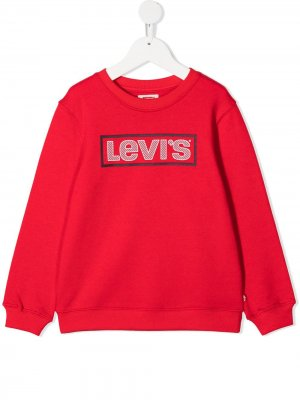

In [100]:
row = sample_df.sample(n=1).iloc[0]
print(row)
images[row['image_name']]

### Upload shards to S3

In [101]:
import s3fs
from utils.s3_utils import upload_folder_to_s3, upload_files_to_s3

s3_client = s3fs.S3FileSystem(
    anon=False,
    key='your_key',
    secret='your_secret_key',
    client_kwargs={
        'endpoint_url': 'your_endpoint_url'
    }
)

In [102]:
error_files = upload_folder_to_s3(
    s3_client,
    source_path=full_shards_dir,
    s3_path='s3_path_to_folder',
)

Found 8 files to upload


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


In [103]:
print(error_files) # should be empty

[]
